In [10]:
import json
import random
import tqdm
from tqdm import tqdm

import numpy as np
import pandas as pd

In [13]:
def load_data(filepath):
    d = {}
    with open(filepath) as f:
        f.seek(0)
        data = f.read(15-10)
    print(data)
    for i, line in enumerate(data):
        d[i] = line
    return d
    
s2orc_path = "/home/jessica/s2orc_8M/s2orc_corpus.jsonl"
d = load_data(s2orc_path)
d

{"pap


{0: '{', 1: '"', 2: 'p', 3: 'a', 4: 'p'}

In [76]:
s2orc = pd.DataFrame.from_dict(d).T
s2orc.head()

,paper_id,title,authors,abstract,year,arxiv_id,acl_id,pmc_id,pubmed_id,doi,...,inbound_citations,has_outbound_citations,has_inbound_citations,has_pdf_parse,has_pdf_parsed_abstract,has_pdf_parsed_body_text,has_pdf_parsed_bib_entries,has_pdf_parsed_ref_entries,s2_url,body_text
0,94551546,Gd(III) ion-chelated supramolecular assemblies...,"[{'first': 'Yu', 'middle': [], 'last': 'Zhao',...",An intricate polymer complex can carry genes t...,2015,None,None,None,None,10.1038/am.2015.67,...,[543091],True,True,True,True,True,True,True,https://api.semanticscholar.org/CorpusID:94551546,"[{'section': 'INTRODUCTION', 'text': 'Gene the..."
1,18980380,Distributionally Robust Counterpart in Markov ...,"[{'first': 'Pengqian', 'middle': [], 'last': '...",This technical note studies Markov decision pr...,2016,1501.07418,None,None,None,10.1109/TAC.2015.2495174,...,"[18980380, 202130625, 12287826, 195316976, 206...",True,True,True,True,True,True,True,https://api.semanticscholar.org/CorpusID:18980380,"[{'section': '', 'text': '. Illustration of th..."
2,18980463,Adult and larval photoreceptors use different ...,"[{'first': 'S. G.', 'middle': [], 'last': 'Spr...",Although development of the adult Drosophila c...,2007,None,None,PMC1950857,17785526,10.1101/gad.1565407,...,"[201966468, 16579577, 14667576, 20024434, 1344...",True,True,True,True,True,True,True,https://api.semanticscholar.org/CorpusID:18980463,"[{'section': '', 'text': 'In spite of the morp..."
3,18981111,Exploration of Unknown Spaces by People Who Ar...,"[{'first': 'Orly', 'middle': [], 'last': 'Laha...",Exploration of unknown spaces is essential for...,2004,None,None,None,None,10.1177/016264340401900302,...,"[6869367, 24873259, 69173440, 12309066, 357763...",True,True,True,False,True,True,True,https://api.semanticscholar.org/CorpusID:18981111,"[{'section': '', 'text': 'The ability to explo..."
4,18981358,Rubber hand illusion induced by touching the f...,"[{'first': 'Michele', 'middle': [], 'last': 'S...",Background: Studies in animals and humans indi...,2014,None,None,PMC4050649,24959128,10.3389/fnhum.2014.00404,...,"[209325151, 206095004, 55701872, 5015858, 5802...",True,True,True,True,True,True,True,https://api.semanticscholar.org/CorpusID:18981358,"[{'section': 'INTRODUCTION', 'text': 'Spinal c..."


In [77]:
from collections import Counter

# finding all possible section names 
section_names_freq = Counter()
for row in s2orc.body_text:
    prev_name = ""
    for para in row:
        if prev_name == para["section"].lower():
            continue
        prev_name = para["section"].lower()
        section_names_freq[prev_name] += 1
    
print(f"Number of unique section names: {len(section_names_freq)}")

Number of unique section names: 621432


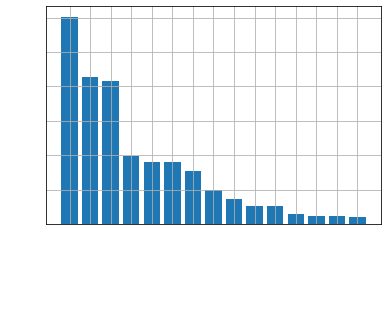

In [78]:
import matplotlib.pyplot as plt

k = 15
topknames = dict(section_names_freq.most_common(k))

fig, ax = plt.subplots()
plt.bar(topknames.keys(), topknames.values())
ax.tick_params(axis="x", colors='white')
ax.tick_params(axis="y", colors='white')
plt.setp(ax.xaxis.get_majorticklabels(), ha="right", rotation=45, rotation_mode="anchor")
plt.grid(True)

plt.show()

In [ ]:
top_section_names = ["introduction", "discussions", "results", "materials", 
                     "conclusions", "methods", "background"]

In [169]:
# finding all section names between a Result section and Discussion section
paper_id_to_section_names_between_results_and_discuss = dict()

for i, row in s2orc.iterrows():
    paper_id = row.paper_id
    body_text = row.body_text
    
    i = 0
    is_results = False
    
    # find the first paragraph from a Result section
    while i < len(body_text) and not is_results:
        section_name = body_text[i]["section"].lower()
        is_results = "result" in section_name or "find" in section_name 
        i += 1
    
    # reject paragraph if it is from a "Result and Discussion" section
    is_discuss = "discuss" in section_name or "conclu" in section_name
    if not is_results or is_discuss: continue
        
    # get chain of section names between this Result para and Discussion section
    chain = []
    if is_results: 
        prev_name = section_name
        
        while i < len(body_text):
            
            # if already at Discussion section, stop looking
            is_discuss = "discuss" in section_name or "conclu" in section_name
            if is_discuss: break

            # avoid repeating section names
            if prev_name != section_name: chain.append(section_name) 
            prev_name = section_name
                      
            section_name = body_text[i]["section"].lower()
            i += 1
        
    if chain: paper_id_to_section_names_between_results_and_discuss[paper_id] = chain

In [170]:
paper_id_to_section_names_between_results_and_discuss

{'18980463': ['embryonic development of the larval eye and initiation of rhodopsin expression',
  'the wts/melt pathway is not involved in the choice of rh5 versus rh6',
  'sal and svp are expressed in distinct pr subtypes',
  'spalt is required for rh5 expression in larval prs',
  'seven-up is required for rh6-subtype specification and to repress rh5-subtype fate'],
 '18981111': ['journal of special education technology'],
 '18981358': ['proprioceptive drift of the real hand toward the rubber hand as a subjective index of perception of the body in space',
  'scores in the questionnaire as a subjective index of ownership of a fake hand',
  'personality, absorption and clinical variables',
  'tas and bfi-10 values (see'],
 '18982127': ['lemma 4. let g be a connected p 5 -free graph which contains a g',
  's] be a set with the smallest d(r) such that i(r) n [s]. then for any steiner tree t of r with',
  'proof.',
  'graphs for which closed neighborhoods of vertices are g n -convex',
  'g

In [158]:
from sentence_transformers import SentenceTransformer, util

# determine if the in-between section names are still results

model = SentenceTransformer('distilbert-base-nli-stsb-mean-tokens')
top_section_names_embeddings = model.encode(top_section_names)

query_section_names = paper_id_to_section_names_between_results_and_discuss['18980463']
print(query_section_names)
query_embeddings = model.encode(query_section_names)

['embryonic development of the larval eye and initiation of rhodopsin expression', 'the wts/melt pathway is not involved in the choice of rh5 versus rh6', 'sal and svp are expressed in distinct pr subtypes', 'spalt is required for rh5 expression in larval prs', 'seven-up is required for rh6-subtype specification and to repress rh5-subtype fate']


In [159]:
cosine_scores = util.pytorch_cos_sim(top_section_names_embeddings, query_embeddings)
pd.DataFrame(np.array(cosine_scores), top_section_names,
             columns=query_section_names)

,embryonic development of the larval eye and initiation of rhodopsin expression,the wts/melt pathway is not involved in the choice of rh5 versus rh6,sal and svp are expressed in distinct pr subtypes,spalt is required for rh5 expression in larval prs,seven-up is required for rh6-subtype specification and to repress rh5-subtype fate
introduction,0.339120,0.052026,0.134131,0.069637,0.202014
discussions,0.080761,0.056082,0.205550,0.095414,0.244850
results,0.093261,0.082832,0.209809,0.057741,0.143554
materials,0.075338,0.126604,0.218352,-0.000480,0.210192
conclusions,0.050217,0.073116,0.191310,0.083733,0.315197
methods,0.065212,0.118168,0.328873,0.102142,0.069500
statistical analysis,-0.015556,0.025430,0.336911,0.040416,0.048823
background,0.084254,0.127791,0.141655,0.009611,0.264998
data analysis,0.166293,0.073217,0.264387,0.136889,0.260359


In [160]:
indexes = np.where(cosine_scores > 0.8)

if len(indexes[0]): 
    print(cosine_scores[indexes])

In [167]:
# apply to all papers with sections between Result and Discussion
top_section_names_embeddings = model.encode(top_section_names)

i = 0
n = 0
for k, v in section_names_between_results_and_discuss.items():
    query_embeddings = model.encode(v)
    cosine_scores = util.pytorch_cos_sim(top_section_names_embeddings, query_embeddings)
    indexes = np.where(cosine_scores > 0.8)
    
    if len(indexes[0]): 
        n += 1
        print(f"{k}: {v}\n")
        
    i += 1
    if i > 1000: break

199662866: ['lds and ais amongst year-2014 hospitalizations', 'results', 'lds and ais amongst year-2014 hospitalizations', 'lds and post-ais outcomes amongst ais population from year 2003-2014', 'odds']

118864492: ['transport of high-energy particles modeling', 'injection', 'diffusion', 'advection', 'non-thermal losses', 'magnetic field', 'target radiation fields', 'maximum particle energies', 'time scales', 'calculation details', 'results', 'dependence on diffusion', 'dependence on magnetic field', 'dependence on the stellar velocity', 'synchrotron emission from the tail']

41515024: ['results', 'sexual recidivism estimates', 'violent recidivism estimates', 'any recidivism estimates', '396']

17433682: ['histopathological evaluation.', 'statistical evaluation.']

40221698: ['algorithm 1: weighted message passing', 'result:', 'assume that n max i , j q i j n o(1) . for any node o ∈ v and its depth t leaf labels˜ prior (c t (o)), define the worst-case misclassification error of a local

25513190: ['introduction', 'methods', 'sample', 'measures', 'statistical analysis', 'sensitivity analyses']

195797193: ['synthesis and characterization of ilcss', 'results', 'synthesis and characterization of ilcss', 'release of gd-nps in vitro', 'biocompatibility', 'mri follow-up in vivo', 'histology of excised cell grafts']

52040261: ['case study: inverted pendulum robot', 'dynamics of two-wheel inverted pendulum', 'control laws', 'maintaining balance', 'results']

9445702: ['lag-3 blockade enhances t cell proliferation and effector function in a self', 'figure 3', 'lag-3 blockade enhances the number and effector function of specific cd8 + t cells in mice with ha-expressing tumors. since lag-3', 'figure 4', 'cd4 + t cells are not required for lag-3-blocking antibody function.', 'figure 5', 'lag-3 blockade restores the ctl activity of endogenous cd8 + t cells.', 'methods', 'mice']

9132225: ['data analysis', 'hedges', 'boosters', 'attitude markers', 'engagement markers', 'self-menti

In [168]:
print(f"# papers with important sections between first Result para and Discussion section: {n}")

# papers with important sections between first Result para and Discussion section: 38
